## PREOPS-1074: Investigate whether forcedSource fluxes used errant PhotoCalibs

Per DM-34019, the LocalPhotoCalib was set after flux measurement, and therefore a default placeholder PhotoCalib was accidentally used to compute fluxes that landed in sourceTables and consolidated visit tables.

It was unclear if this is also a problem for the forcedSourceTable, or not. The goal of this notebook was to find out.

**Conclusion**: the forcedSourceTable fluxes, while not identical to manually calibrated src fluxes (because forced photometry inherently does not fit the source position), appears reasonably consistent! DM-34019 did not affect it.

In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from astropy.coordinates import SkyCoord
import astropy.units as u
#from statsmodels.stats.weightstats import DescrStatsW
#from scipy.stats import median_abs_deviation

import lsst.geom
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

### Load butler and collections, and set default skymap, instrument, etc.

In [2]:
butler = dafButler.Butler(config="s3://butler-us-central1-panda-dev/dc2/butler-external.yaml")

In [3]:
# collection1 is the shallower tracts 3828 and 3829
# collection2 is the deeper tract 4431

collection1 = '2.2i/runs/test-med-1/v23_0_0_rc2/PREOPS-863'
collection2 = '2.2i/runs/test-tract4431/v23_0_0_rc2/PREOPS-728'

In [4]:
skymap = 'DC2'
instrument = 'LSSTCam-imSim'
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)

In [5]:
oneForcedSourceTable = butler.get('forcedSourceTable', collections=collection1,
                            tract=3828, patch=47,
                            skymap=skymap, instrument=instrument)

In [6]:
oneForcedSourceTable.columns

Index(['objectId', 'parentObjectId', 'coord_ra', 'coord_dec', 'ccdVisitId',
       'band', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfDiffFlux',
       'psfDiffFluxErr', 'psfDiffFlux_flag', 'localPhotoCalib',
       'localPhotoCalib_flag', 'localPhotoCalibErr', 'localWcs_flag',
       'localWcs_CDMatrix_2_1', 'localWcs_CDMatrix_1_1',
       'localWcs_CDMatrix_1_2', 'localWcs_CDMatrix_2_2',
       'localBackground_instFlux', 'localBackground_instFluxErr',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'skymap', 'tract',
       'patch', 'detect_isPrimary', 'detect_isTractInner',
       'detect_isPatchInner'],
      dtype='object')

### This is how you get visits and detectors from a ccdVisitId and I should stop forgetting it

In [7]:
dataId = packer.unpack(oneForcedSourceTable.ccdVisitId)
oneForcedSourceTable['visit'] = dataId['visit']
oneForcedSourceTable['detector'] = dataId['detector']

### Make our lives less awful by only considering "primary" forced sources in the inner tract + patch

We'll call this `oneForcedSourceTable_good`

In [8]:
oneForcedSourceTable_good = oneForcedSourceTable.loc[(oneForcedSourceTable['detect_isTractInner'] == True) & \
                                                     (oneForcedSourceTable['detect_isPatchInner'] == True) &\
                                                     (oneForcedSourceTable['detect_isPrimary'] == True)]

In [9]:
# Arbitrarily use the zeroth entry as a test case
oneForcedSourceTable_good.head(1)

,objectId,parentObjectId,coord_ra,coord_dec,ccdVisitId,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,...,pixelFlags_crCenter,pixelFlags_suspectCenter,skymap,tract,patch,detect_isPrimary,detect_isTractInner,detect_isPatchInner,visit,detector
forcedSourceId,,,,,,,,,,,,,,,,,,,,,
266818987612974018,1650314176733642968,0,55.981,-35.88873,496989093,i,152.510481,340.671262,False,-26.664465,...,False,False,DC2,3828,47,True,True,True,496989,93


In [11]:
# Look at the existing combos of visit, detector, and band, and sort by most common
c = Counter(zip(oneForcedSourceTable_good['visit'],
                oneForcedSourceTable_good['detector'],
                oneForcedSourceTable_good['band']))
c.most_common()

[((428492, 6, 'i'), 12492),
 ((427030, 117, 'z'), 12179),
 ((496989, 94, 'i'), 12078),
 ((179999, 11, 'u'), 11659),
 ((277060, 73, 'u'), 11608),
 ((416955, 5, 'r'), 11544),
 ((398413, 37, 'r'), 11241),
 ((189318, 73, 'y'), 11185),
 ((484266, 127, 'g'), 10963),
 ((211141, 32, 'i'), 10944),
 ((254379, 7, 'g'), 10623),
 ((174534, 45, 'i'), 10620),
 ((426672, 111, 'z'), 10531),
 ((433992, 164, 'i'), 10412),
 ((400440, 10, 'g'), 10374),
 ((472179, 42, 'i'), 10365),
 ((457681, 139, 'i'), 10285),
 ((433038, 89, 'u'), 10024),
 ((206073, 116, 'y'), 9930),
 ((466756, 49, 'u'), 9907),
 ((410996, 106, 'i'), 9892),
 ((167863, 45, 'y'), 9877),
 ((397330, 117, 'i'), 9869),
 ((202627, 2, 'r'), 9796),
 ((451502, 1, 'r'), 9790),
 ((266118, 185, 'y'), 9647),
 ((244028, 125, 'i'), 9562),
 ((419000, 97, 'g'), 9516),
 ((254381, 33, 'g'), 9502),
 ((443127, 135, 'y'), 9482),
 ((407950, 6, 'y'), 9462),
 ((207784, 32, 'y'), 9446),
 ((466279, 61, 'g'), 9355),
 ((214465, 134, 'i'), 9299),
 ((159491, 161, 'g'), 92

In [12]:
# Manually use the same visit and detector as the test case above
oneSourceTable = butler.get('sourceTable', collections=collection1,
                             tract=3828, patch=47,
                             skymap=skymap, instrument=instrument,
                             visit=496989, detector=94)

In [13]:
oneSourceTable.head(1)

,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,decl,...,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,band,instrument,detector,physical_filter,visit_system,visit
sourceId,,,,,,,,,,,,,,,,,,,,,
266818988149833729,56.022153,-35.676416,496989094,0,3139.0,6.0,NaN,NaN,56.022153,-35.676416,...,False,False,False,True,i,LSSTCam-imSim,94,i_sim_1.4,1,496989


In [14]:
list(oneSourceTable.columns)  # soooo many

['coord_ra',
 'coord_dec',
 'ccdVisitId',
 'parentSourceId',
 'x',
 'y',
 'xErr',
 'yErr',
 'ra',
 'decl',
 'calibFlux',
 'calibFluxErr',
 'ap03Flux',
 'ap03FluxErr',
 'ap03Flux_flag',
 'ap06Flux',
 'ap06FluxErr',
 'ap06Flux_flag',
 'ap09Flux',
 'ap09FluxErr',
 'ap09Flux_flag',
 'ap12Flux',
 'ap12FluxErr',
 'ap12Flux_flag',
 'ap17Flux',
 'ap17FluxErr',
 'ap17Flux_flag',
 'ap25Flux',
 'ap25FluxErr',
 'ap25Flux_flag',
 'ap35Flux',
 'ap35FluxErr',
 'ap35Flux_flag',
 'ap50Flux',
 'ap50FluxErr',
 'ap50Flux_flag',
 'ap70Flux',
 'ap70FluxErr',
 'ap70Flux_flag',
 'sky',
 'skyErr',
 'psfFlux',
 'psfFluxErr',
 'ixx',
 'iyy',
 'ixy',
 'ixxPSF',
 'iyyPSF',
 'ixyPSF',
 'extendedness',
 'localPhotoCalib',
 'localPhotoCalib_flag',
 'localPhotoCalibErr',
 'localWcs_flag',
 'localWcs_CDMatrix_2_1',
 'localWcs_CDMatrix_1_1',
 'localWcs_CDMatrix_1_2',
 'localWcs_CDMatrix_2_2',
 'blendedness_abs',
 'blendedness_flag',
 'blendedness_flag_noCentroid',
 'blendedness_flag_noShape',
 'apFlux_12_0_flag',
 'apFl

### Crossmatch o'clock between the forcedSourceTable and the sourceTable

Can't do this with sourceId and forcedSourceId because they're totally unrelated; have to do a spatial crossmatch

In [15]:
forcedSourceCoords = SkyCoord(ra=oneForcedSourceTable_good.coord_ra.values*u.degree,
                              dec=oneForcedSourceTable_good.coord_dec.values*u.degree)
sourceCoords = SkyCoord(ra=oneSourceTable.coord_ra.values*u.degree, dec=oneSourceTable.coord_dec.values*u.degree)

In [16]:
idx, d2d, d3d = forcedSourceCoords.match_to_catalog_sky(sourceCoords)

In [17]:
# Only keep matches within 0.5 arcseconds
good_match = d2d < 0.5*u.arcsec
forcedSourceMatches = forcedSourceCoords[good_match]
sourceMatches = sourceCoords[idx[good_match]]

In [18]:
len(forcedSourceMatches)

143202

In [19]:
len(d2d)

1574974

<IPython.core.display.Javascript object>


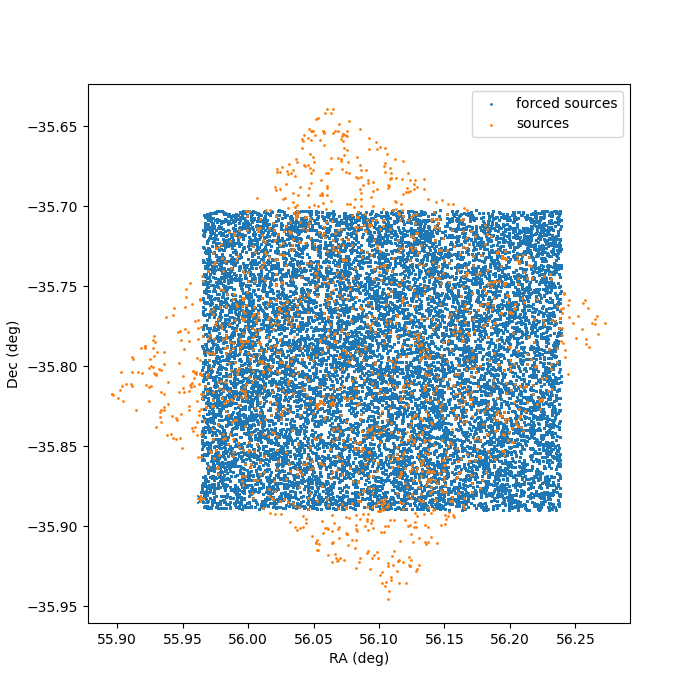

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(oneForcedSourceTable_good.coord_ra, oneForcedSourceTable_good.coord_dec, s=1, label='forced sources')
plt.scatter(oneSourceTable.coord_ra, oneSourceTable.coord_dec, s=1, label='sources')
plt.scatter(55.964162, -35.883092, marker='x', c='C0')
plt.scatter(55.964086, -35.882998, marker='+', c='C1')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend()

### It's a spatial overlap!

When we used detector 93, the overlap was tiny, but with detector 94, the overlap is much better. Now we can pick a random coordinate from the matched table and look at how the fluxes compare. (Recall `forcedSourceMatches` is the dataframe we got when we spatially cross-matched the forcedSourceTable and the sourceTable, and earlier we had a test case forcedSourceId with visit=496989, so we'll stick with that here.)

In [24]:
print(forcedSourceMatches[0].ra.value, forcedSourceMatches[0].dec.value)

56.106851807889704 -35.755002125461516


In [25]:
oneForcedSourceTable_good.loc[(oneForcedSourceTable_good.coord_ra == forcedSourceMatches[0].ra.value) & 
                              (oneForcedSourceTable_good.coord_dec == forcedSourceMatches[0].dec.value) &
                              (oneForcedSourceTable_good.visit == 496989)]\
            [['coord_ra', 'coord_dec', 'visit', 'psfFlux', 'psfFluxErr', 'localPhotoCalib', 'localPhotoCalibErr', 'band']]

,coord_ra,coord_dec,visit,psfFlux,psfFluxErr,localPhotoCalib,localPhotoCalibErr,band
forcedSourceId,,,,,,,,
266818988149838675,56.106852,-35.755002,496989,1649.026872,345.306445,0.661266,0.000228,i


In [26]:
print(sourceMatches[0].ra.value, forcedSourceMatches[0].dec.value)

56.106778206168 -35.755002125461516


In [27]:
oneSourceTable.loc[(oneSourceTable.coord_ra == sourceMatches[0].ra.value) & 
                   (oneSourceTable.coord_dec == sourceMatches[0].dec.value)] \
            [['coord_ra', 'coord_dec', 'visit', 'psfFlux', 'psfFluxErr', 'localPhotoCalib', 'localPhotoCalibErr', 'band']]

,coord_ra,coord_dec,visit,psfFlux,psfFluxErr,localPhotoCalib,localPhotoCalibErr,band
sourceId,,,,,,,,
266818988149834461,56.106778,-35.754993,496989,2052.142481,398.819258,0.763623,0.0,i


### The psfFluxes and photoCalibs are different!

We are pretty confident the sourceTable has incorrect localPhotoCalibs and thus calibrated fluxes, especially given that _highly suspicious_ error value of 0, but just because the forcedSourceTable is different doesn't necessarily mean its calibrated `psfFlux` is correct. Let's load up a `src` and see what the `instFlux` started out as.

Naturally, `src` is an AFW situation and has everything in radians

In [28]:
src = butler.get('src', collections=collection1, instrument=instrument, visit=496989, detector=94)
oneSrc = src.asAstropy().to_pandas()  # thank heavens

In [29]:
oneSrc['ra_deg'] = oneSrc.coord_ra.values*u.rad.to(u.deg)
oneSrc['dec_deg'] = oneSrc.coord_dec.values*u.rad.to(u.deg)

In [30]:
list(oneSrc.columns)

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'calib_detected',
 'calib_psf_candidate',
 'calib_psf_used',
 'calib_psf_reserved',
 'deblend_nChild',
 'deblend_deblendedAsPsf',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psf_instFlux',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_skipped',
 'deblend_rampedTemplate',
 'deblend_patchedTemplate',
 'deblend_hasStrayFlux',
 'deblend_peak_center_x',
 'deblend_peak_center_y',
 'deblend_peakId',
 'deblend_nPeaks',
 'deblend_parentNPeaks',
 'sky_source',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_SdssCentroid_x',
 'slot_Centroid_x',
 'base_SdssCentroid_y',
 'slot_Centroid_y',
 'base_SdssCentroid_xErr',
 'slot_Centroid_xErr',
 'base_SdssCentroid_yErr',
 'slot_Centroid_yErr',
 'base_SdssCentroid_flag',
 'base_CircularApertureFlux_flag_badCentroid',
 '

### While we're here, let's look at the calexp that goes with this src and make sure nothing is immediately awful

In [31]:
calexp = butler.get('calexp', collections=collection1, instrument=instrument, visit=496989, detector=94)

<IPython.core.display.Javascript object>


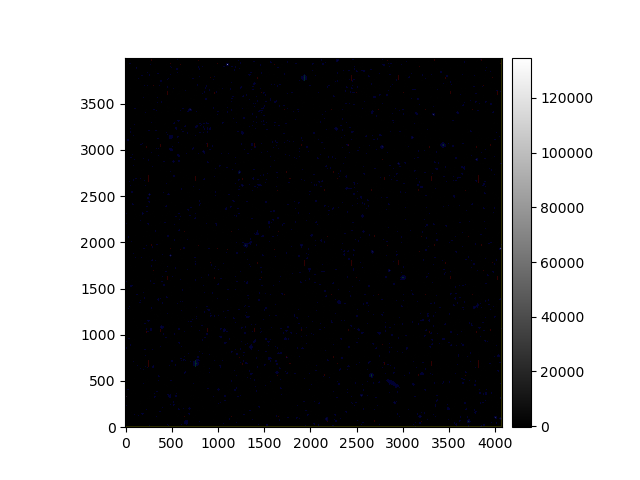

In [32]:
display1 = afwDisplay.Display(frame=2)
display1.setMaskTransparency(80)
display1.mtv(calexp)

<IPython.core.display.Javascript object>


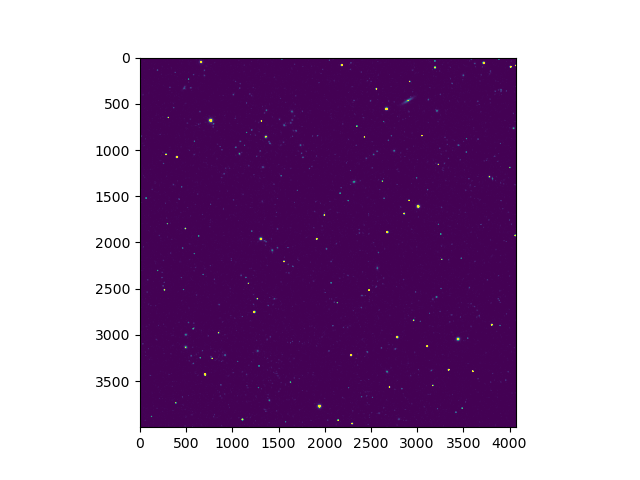

In [33]:
plt.figure()
plt.imshow(calexp.maskedImage.image.array, vmin=0, vmax=1000)

### Anyway, matching is fun, let's do it again, this time with forcedSourceTable and src

In [34]:
forcedSourceCoords = SkyCoord(ra=oneForcedSourceTable_good.coord_ra.values*u.degree,
                              dec=oneForcedSourceTable_good.coord_dec.values*u.degree)
srcCoords = SkyCoord(ra=oneSrc.ra_deg.values*u.degree, dec=oneSrc.dec_deg.values*u.degree)

In [35]:
idx, d2d, d3d = srcCoords.match_to_catalog_sky(forcedSourceCoords)

In [36]:
# Only keep matches within 0.5 arcseconds
good_match = d2d < 0.5*u.arcsec
srcMatches = srcCoords[good_match]
forcedSourceMatches = forcedSourceCoords[idx[good_match]]

In [37]:
print(len(srcMatches), len(forcedSourceMatches))

1291 1291


In [38]:
len(d2d)

1889

Next, we'll load the photoCalib object, which is where all this photoCalib stuff originates, and use the built-in photoCalib methods to calibrate the src's instrumental fluxes

In [39]:
photoCalib = butler.get('calexp.photoCalib', collections=collection1, instrument=instrument,
                        visit=496989, detector=94)

In [40]:
calibSrc = photoCalib.calibrateCatalog(src, ['base_PsfFlux']).asAstropy().to_pandas()

In [41]:
calibSrc

,id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,...,calib_photometry_used,calib_photometry_reserved,base_PsfFlux_flux,slot_PsfFlux_flux,base_PsfFlux_mag,slot_PsfFlux_mag,base_PsfFlux_fluxErr,slot_PsfFlux_fluxErr,base_PsfFlux_magErr,slot_PsfFlux_magErr
0,266818988149833729,0.977771,-0.622671,0,False,False,False,False,0,False,...,False,False,1976.095190,1976.095190,23.160480,23.160480,344.150208,344.150208,0.189088,0.189088
1,266818988149833730,0.978289,-0.622129,0,False,False,False,False,0,False,...,False,False,7018.184353,7018.184353,21.784438,21.784438,351.375330,351.375330,0.054359,0.054359
2,266818988149833731,0.977128,-0.623361,0,False,False,False,False,0,False,...,False,False,8540.370808,8540.370808,21.571308,21.571308,359.143525,359.143525,0.045658,0.045658
3,266818988149833732,0.978192,-0.622236,0,False,False,False,False,0,False,...,False,False,7391.093088,7391.093088,21.728228,21.728228,351.957875,351.957875,0.051702,0.051702
4,266818988149833733,0.976954,-0.623541,0,False,False,False,False,0,False,...,False,False,1859.871269,1859.871269,23.226293,23.226293,346.073434,346.073434,0.202027,0.202027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,266818988149835613,0.979536,-0.626993,266818988149835239,False,False,False,False,0,True,...,False,False,2202.063544,2202.063544,23.042925,23.042925,344.514022,344.514022,0.169864,0.169864
1885,266818988149835614,0.981301,-0.625191,266818988149835256,False,False,False,False,0,True,...,False,False,4676.446041,4676.446041,22.225210,22.225210,348.884389,348.884389,0.081001,0.081001
1886,266818988149835615,0.981303,-0.625182,266818988149835256,False,False,False,False,0,True,...,False,False,3078.408095,3078.408095,22.679185,22.679185,345.835103,345.835103,0.121974,0.121974
1887,266818988149835616,0.980909,-0.625656,266818988149835264,True,True,True,False,0,False,...,True,False,652477.135201,652477.135201,16.863587,16.863587,1040.966775,1040.966775,0.001732,0.001732


In [42]:
calibSrc.base_PsfFlux_flux

0         1976.095190
1         7018.184353
2         8540.370808
3         7391.093088
4         1859.871269
            ...      
1884      2202.063544
1885      4676.446041
1886      3078.408095
1887    652477.135201
1888      3196.526036
Name: base_PsfFlux_flux, Length: 1889, dtype: float64

In [43]:
idx[good_match]  # these are indices from forcedSource that correspond to srcs

array([ 734513,  621482, 1059668, ...,  277429, 1545410,  362724])

### Calculate difference between forcedSource fluxes and src fluxes, using the coord matching

This happens to be an i-band visit

In [44]:
fluxDiff = oneForcedSourceTable_good.iloc[idx[good_match]]['psfFlux'].values \
           - calibSrc.iloc[good_match]['base_PsfFlux_flux'].values

<IPython.core.display.Javascript object>


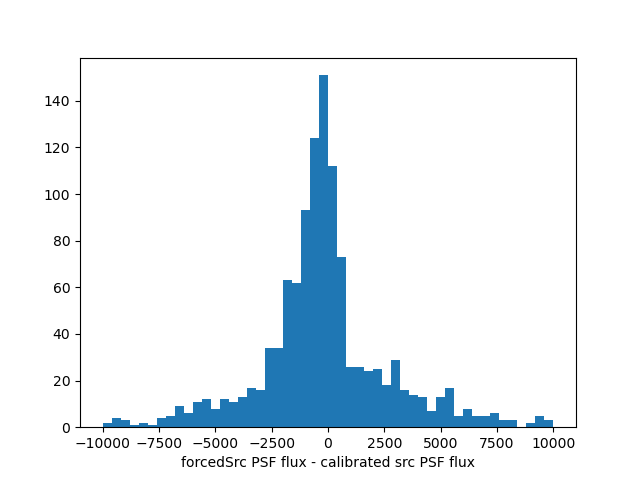

Text(0.5, 0, 'forcedSrc PSF flux - calibrated src PSF flux')

In [48]:
plt.figure()
plt.hist(fluxDiff, bins=50, range=(-10000, 10000))
plt.xlabel('forcedSrc PSF flux - calibrated src PSF flux')

Ooookay. That has maybe a bit more variation than I naively expected, but there is a big peak near zero, and it's not super skewed looking, these forcedSrc fluxes look pretty promising as-is.

In [49]:
calibSrcErr = calibSrc.iloc[good_match]['base_PsfFlux_fluxErr'].values
fluxDiff/calibSrcErr

array([ -2.02583345,  -3.4646715 , -14.44859533, ...,  -2.60546842,
        -0.16828479,   1.44116525])

<IPython.core.display.Javascript object>


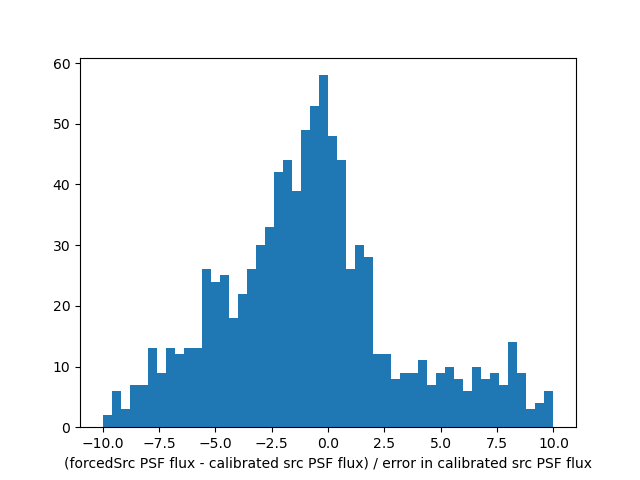

Text(0.5, 0, '(forcedSrc PSF flux - calibrated src PSF flux) / error in calibrated src PSF flux')

In [51]:
plt.figure()
plt.hist(fluxDiff/calibSrcErr, bins=50, range=(-10, 10))
plt.xlabel('(forcedSrc PSF flux - calibrated src PSF flux) / error in calibrated src PSF flux')

In [52]:
forcedSrcErr = oneForcedSourceTable_good.iloc[idx[good_match]]['psfFluxErr'].values
fluxDiff/forcedSrcErr

array([ -2.64057478,  -6.54123471, -21.22900119, ...,  -4.17457043,
        -0.16389043,   4.28526653])

<IPython.core.display.Javascript object>


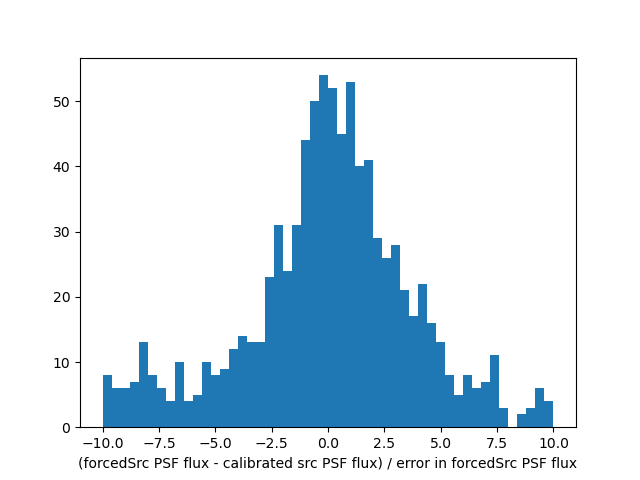

Text(0.5, 0, '(forcedSrc PSF flux - calibrated src PSF flux) / error in forcedSrc PSF flux')

In [53]:
plt.figure()
plt.hist(fluxDiff/forcedSrcErr, bins=50, range=(-10, 10))
plt.xlabel('(forcedSrc PSF flux - calibrated src PSF flux) / error in forcedSrc PSF flux')

### Repeat what we just did for other bands

* 427030, 117, 'z'
* 496989, 94, 'i' (already done)
* 179999, 11, 'u'
* 416955, 5, 'r'
* 189318, 73, 'y'
* 484266, 127, 'g'

In [60]:
def inspectFluxDiff(forcedSourceTable, visit, detector, band, ytext=-10):

    oneSourceTable = butler.get('sourceTable', collections=collection1,
                                 instrument=instrument, visit=visit, detector=detector)
    src = butler.get('src', collections=collection1, instrument=instrument, visit=visit, detector=detector)
    oneSrc = src.asAstropy().to_pandas()
    oneSrc['ra_deg'] = oneSrc.coord_ra.values*u.rad.to(u.deg)
    oneSrc['dec_deg'] = oneSrc.coord_dec.values*u.rad.to(u.deg)
    
    forcedSourceCoords = SkyCoord(ra=forcedSourceTable.coord_ra.values*u.degree,
                              dec=forcedSourceTable.coord_dec.values*u.degree)
    srcCoords = SkyCoord(ra=oneSrc.ra_deg.values*u.degree, dec=oneSrc.dec_deg.values*u.degree)
    
    idx, d2d, d3d = srcCoords.match_to_catalog_sky(forcedSourceCoords)

    # Only keep matches within 0.5 arcseconds
    good_match = d2d < 0.5*u.arcsec
    srcMatches = srcCoords[good_match]
    forcedSourceMatches = forcedSourceCoords[idx[good_match]]

    photoCalib = butler.get('calexp.photoCalib', collections=collection1, instrument=instrument,
                            visit=visit, detector=detector)
    calibSrc = photoCalib.calibrateCatalog(src, ['base_PsfFlux']).asAstropy().to_pandas()

    fluxDiff = oneForcedSourceTable_good.iloc[idx[good_match]]['psfFlux'].values \
               - calibSrc.iloc[good_match]['base_PsfFlux_flux'].values

    calibSrcErr = calibSrc.iloc[good_match]['base_PsfFlux_fluxErr'].values
    forcedSrcErr = oneForcedSourceTable_good.iloc[idx[good_match]]['psfFluxErr'].values

    fig, axs = plt.subplots(2, 2)
    plt.suptitle(f'flux difference, {band} band, visit {visit}, detector {detector}')
    axs[0,0].hist(fluxDiff, bins=50, range=(-10000, 10000))

    axs[1,0].hist(fluxDiff/calibSrcErr, bins=50, range=(-10, 10))
    plt.text(-38, ytext, 'fluxDiff / err in calibrated src PsfFlux')

    axs[1,1].hist(fluxDiff/forcedSrcErr, bins=50, range=(-10, 10))
    plt.text(-10, ytext, 'fluxDiff / err in forcedSrc PsfFlux')
    
    axs[0,1].axis('off')

<IPython.core.display.Javascript object>


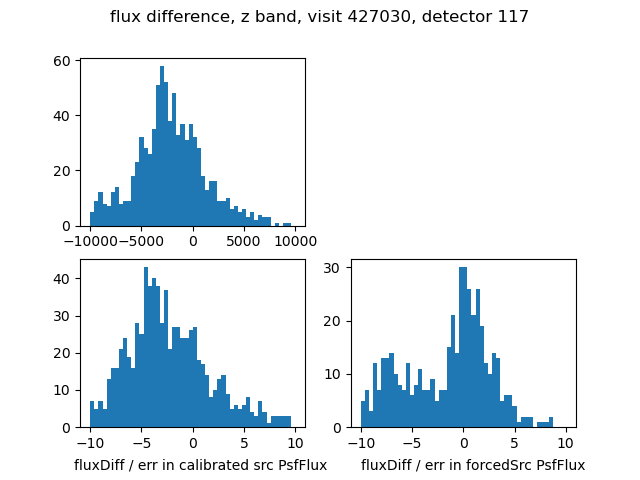

In [61]:
inspectFluxDiff(oneForcedSourceTable_good, visit=427030, detector=117, band='z', ytext=-8)

<IPython.core.display.Javascript object>


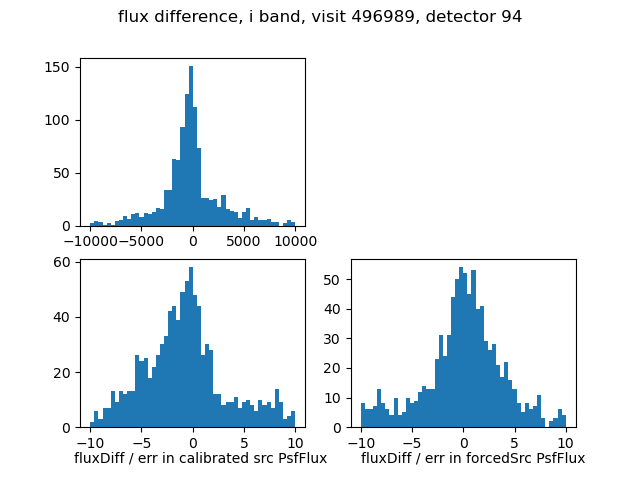

In [62]:
inspectFluxDiff(oneForcedSourceTable_good, visit=496989, detector=94, band='i', ytext=-12)  # original test case

<IPython.core.display.Javascript object>


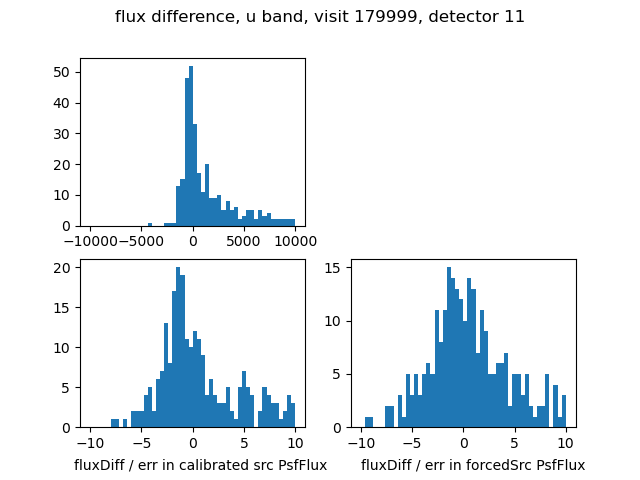

In [63]:
inspectFluxDiff(oneForcedSourceTable_good, visit=179999, detector=11, band='u', ytext=-4)

<IPython.core.display.Javascript object>


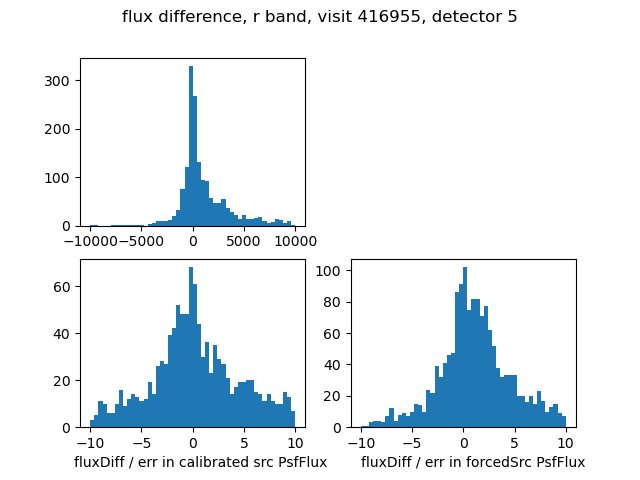

In [64]:
inspectFluxDiff(oneForcedSourceTable_good, visit=416955, detector=5, band='r', ytext=-25)

<IPython.core.display.Javascript object>


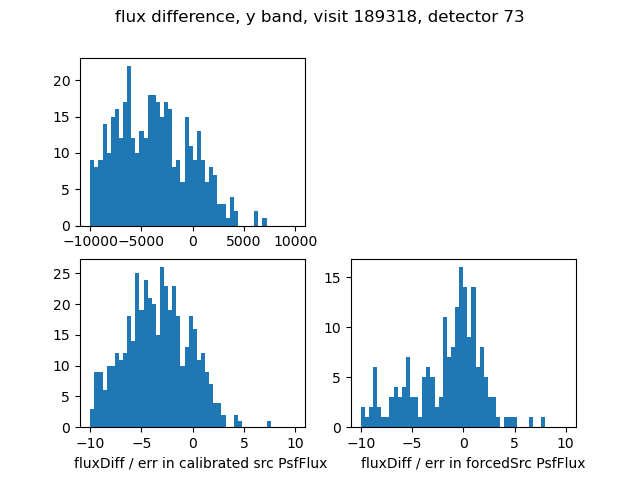

In [65]:
inspectFluxDiff(oneForcedSourceTable_good, visit=189318, detector=73, band='y', ytext=-4)

<IPython.core.display.Javascript object>


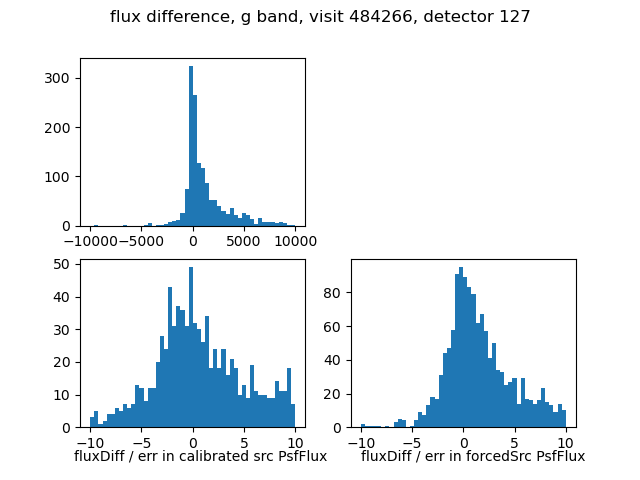

In [66]:
inspectFluxDiff(oneForcedSourceTable_good, visit=484266, detector=127, band='g', ytext=-20)